In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\RSS")

In [3]:
##read datasets
df=pd.read_csv(os.getcwd()+r"\Data Files\export_concatenated.csv")

In [4]:
df.SOURCE_ID.value_counts()

CIBIL    1565146
Name: SOURCE_ID, dtype: int64

In [5]:
df.head()

,Unnamed: 0,SKP_CREDIT_CASE,TIME_DECISION_DATE,CLIENT_EXI_3M,RISK_FPD30,RISK_FSTQPD30,RISK_FSTQPD60,SOURCE_ID,ADDRESS_CNT,ZIPCODE_CNT,...,OFFICE_ZIPCODE_ADDRESS_RAT,OFFICE_ADDRESS_PCT,PERMANENT_ADDRESS_CNT,PERMANENT_ZIPCODE_CNT,PERMANENT_ZIPCODE_ADDRESS_RAT,PERMANENT_ADDRESS_PCT,PERMANENT_OFFICE_COMB_RAT,RESIDENT_OFFICE_COMB_RAT,PERMANENT_RESIDENCE_COMB_RAT,RISK_SCORE
0,0,237496224,01-06-19,N,0,0,0,CIBIL,1,1,...,NaN,0.0,0,0,NaN,0.0000,NaN,1.0,1.0,0.019349
1,1,237502602,02-06-19,N,0,0,0,CIBIL,2,2,...,1.0,0.5,0,0,NaN,0.0000,1.0,1.0,1.0,0.001576
2,2,237504476,01-06-19,N,0,0,0,CIBIL,3,2,...,NaN,0.0,1,1,1.0,0.3333,1.0,1.0,0.5,0.020674
3,3,237513079,01-06-19,Y,0,0,0,CIBIL,2,1,...,NaN,0.0,0,0,NaN,0.0000,NaN,1.0,1.0,0.022167
4,4,237513656,01-06-19,Y,0,0,0,CIBIL,2,2,...,NaN,0.0,0,0,NaN,0.0000,NaN,1.0,1.0,0.054746


In [6]:
df.dropna(subset=['RISK_SCORE'],inplace=True)

In [7]:
df = df[(df["SOURCE_ID"]=="CIBIL")&(df["CLIENT_EXI_3M"]=="N")]

<AxesSubplot:ylabel='Frequency'>

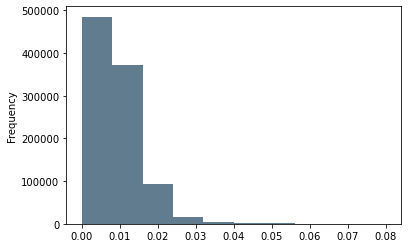

In [8]:
# Check distribution of scores
pd.Series(df['RISK_SCORE']).plot.hist(bins=10, range=(0,0.08) ,color='#607c8e')

In [9]:
hcc_score='RISK_SCORE'

# HCC score Gini         
metric_auc_hcc = metrics.roc_auc_score(df['RISK_FSTQPD30'], df[hcc_score])
gini_hcc_only = 2 * metric_auc_hcc - 1
print("HCIN SCORE GINI:" ,gini_hcc_only)

HCIN SCORE GINI: 0.32845107708805865


In [10]:
df["TIME_DECISION_DATE"] = pd.to_datetime(df["TIME_DECISION_DATE"],format ='%d-%m-%y')

df["MONTH"]= df["TIME_DECISION_DATE"].dt.strftime("%y-%m")

In [11]:
df_summ = df.groupby("MONTH").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

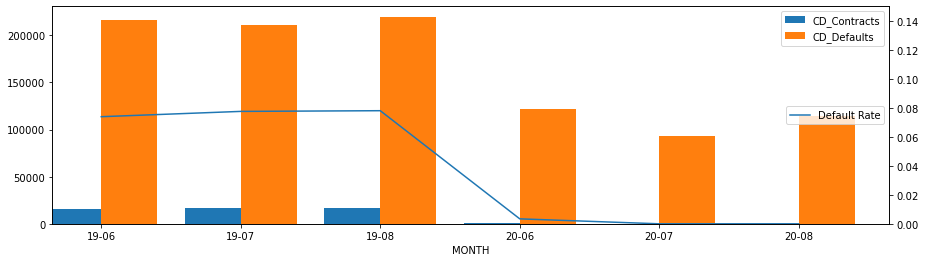

In [12]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [13]:
#MOM Gini Risk Score
for x in df["MONTH"].unique():
    try:   
        metric_auc_hcc = metrics.roc_auc_score(df[df["MONTH"]==x]['RISK_FSTQPD30'], df[df["MONTH"]==x][hcc_score])
        gini_hcc_only = 2 * metric_auc_hcc - 1
        print(x ,gini_hcc_only)  
    except:
        print("ERROR")

19-06 0.22989068911468058
19-07 0.22130626960908484
19-08 0.21593942692903778
20-06 0.26430208829960367
ERROR
ERROR


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,976644.0,2.684885e+05,1.986942e+05,0.000000e+00,1.032755e+05,2.270125e+05,3.964542e+05,7.507990e+05
SKP_CREDIT_CASE,976644.0,2.665342e+08,3.207717e+07,2.374962e+08,2.419142e+08,2.470449e+08,3.082744e+08,3.162179e+08
RISK_FPD30,976644.0,1.610106e-02,1.258643e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTQPD30,976644.0,5.113224e-02,2.202675e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
RISK_FSTQPD60,976644.0,3.695512e-02,1.886517e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
ADDRESS_CNT,976644.0,1.650201e+00,1.019081e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00
ZIPCODE_CNT,976644.0,1.270448e+00,5.912326e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00
ZIPCODE_ADDRESS_RAT,976644.0,8.741985e-01,2.282643e-01,0.000000e+00,7.500000e-01,1.000000e+00,1.000000e+00,3.000000e+00
RESIDENCE_ADDRESS_CNT,976644.0,9.621438e-01,5.560192e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00
RESIDENCE_ZIPCODE_CNT,976644.0,8.946965e-01,4.486715e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00


In [15]:
df_test = df[df["TIME_DECISION_DATE"]>= pd.datetime(2019,7,1)]
df_train = df[df["TIME_DECISION_DATE"]< pd.datetime(2019,7,1)]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [16]:
df.columns

Index(['Unnamed: 0', 'SKP_CREDIT_CASE', 'TIME_DECISION_DATE', 'CLIENT_EXI_3M',
       'RISK_FPD30', 'RISK_FSTQPD30', 'RISK_FSTQPD60', 'SOURCE_ID',
       'ADDRESS_CNT', 'ZIPCODE_CNT', 'ZIPCODE_ADDRESS_RAT',
       'RESIDENCE_ADDRESS_CNT', 'RESIDENCE_ZIPCODE_CNT',
       'RESIDENCE_ZIPCODE_ADDRESS_RAT', 'RESIDENCE_ADDRESS_PCT',
       'OFFICE_ADDRESS_CNT', 'OFFICE_ZIPCODE_CNT',
       'OFFICE_ZIPCODE_ADDRESS_RAT', 'OFFICE_ADDRESS_PCT',
       'PERMANENT_ADDRESS_CNT', 'PERMANENT_ZIPCODE_CNT',
       'PERMANENT_ZIPCODE_ADDRESS_RAT', 'PERMANENT_ADDRESS_PCT',
       'PERMANENT_OFFICE_COMB_RAT', 'RESIDENT_OFFICE_COMB_RAT',
       'PERMANENT_RESIDENCE_COMB_RAT', 'RISK_SCORE', 'MONTH'],
      dtype='object')

In [17]:
x_column = ['ADDRESS_CNT', 'ZIPCODE_CNT', 'ZIPCODE_ADDRESS_RAT',
       'RESIDENCE_ADDRESS_CNT', 'RESIDENCE_ZIPCODE_CNT',
       'RESIDENCE_ZIPCODE_ADDRESS_RAT', 'RESIDENCE_ADDRESS_PCT',
       'OFFICE_ADDRESS_CNT', 'OFFICE_ZIPCODE_CNT',
       'OFFICE_ZIPCODE_ADDRESS_RAT', 'OFFICE_ADDRESS_PCT',
       'PERMANENT_ADDRESS_CNT', 'PERMANENT_ZIPCODE_CNT',
       'PERMANENT_ZIPCODE_ADDRESS_RAT', 'PERMANENT_ADDRESS_PCT',
       'PERMANENT_OFFICE_COMB_RAT', 'RESIDENT_OFFICE_COMB_RAT',
       'PERMANENT_RESIDENCE_COMB_RAT','RISK_SCORE']
y_column = 'RISK_FSTQPD30'

In [18]:
# split data into train and test sets
seed = 25522

X_test = df_test[x_column]
y_test = df_test[y_column]

X_train, X_valid, y_train, y_valid = train_test_split(df_train[x_column], df_train[y_column], test_size=0.2, random_state=seed)


##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid) / len(y_valid)))
print("\n validation set shape:",X_valid.shape)
print("\n Train GINI",  metrics.roc_auc_score(y_train, X_train['RISK_SCORE'])*2 -1)
print("\n Test GINI",  metrics.roc_auc_score(y_test, X_test['RISK_SCORE'])*2 -1)
print("\n validation GINI",  metrics.roc_auc_score(y_valid, X_valid['RISK_SCORE'])*2 -1)



Event rate in train set : 7.40%

 Train set shape: (173264, 19)

Event rate in test set : 4.46%

 Test set shape: (760063, 19)

Event rate in validation set : 7.33%

 validation set shape: (43317, 19)

 Train GINI 0.23079389512780568

 Test GINI 0.3485721247351852

 validation GINI 0.2262753093205392


In [19]:
## Variable importance
def fimportances(xc, predictors):
    importances = pd.DataFrame({'predictor': predictors, 'importance': xc.feature_importances_})
    importances = importances[importances['importance'] > 0]
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.reset_index(inplace=True, drop=True)
    importances = importances[['predictor', 'importance']]
    return importances

In [20]:
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

evals=[(X_train.drop(columns='RISK_SCORE'), np.ravel(y_train)),(X_valid.drop(columns='RISK_SCORE'), np.ravel(y_valid))]

bst = xgb_model.fit(X_train.drop(columns='RISK_SCORE'), np.ravel(y_train), eval_metric="auc", eval_set=evals,
                    early_stopping_rounds=40   ,  verbose=False)

In [21]:
imp = fimportances(bst,X_train.drop(columns='RISK_SCORE').columns)

In [22]:
bst1 = bst
X_train_1 = X_train.drop(columns='RISK_SCORE')
X_valid_1 = X_valid.drop(columns='RISK_SCORE')
select_X_train = X_train_1

dic_imp = {"n":[imp.shape[0]],"Gini Train":[0],"Gini Test":[0],"Predictors":[list(imp['predictor'])]}

while(select_X_train.shape[1] > 2):
    select_X_train = X_train_1[list(imp['predictor'])[:-1]]
    select_X_valid = X_valid_1[list(imp['predictor'])[:-1]]
    xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

    evals=[(select_X_train, np.ravel(y_train)),(select_X_valid, np.ravel(y_valid))]

    bst = xgb_model.fit(select_X_train, np.ravel(y_train), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=40   ,  verbose=False)
    
    ypred_train = bst.predict_proba(select_X_train)[:, 1]
    ypred_test  = bst.predict_proba(select_X_valid)[:, 1]
    
    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_valid, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1
    
    print("Columns Remaining : %d , gini_train: %f,gini_test: %f "%(select_X_train.shape[1],gini_train,gini_test))
    
    dic_imp['n'].append(imp.shape[0])
    dic_imp['Gini Train'].append(gini_train)
    dic_imp['Gini Test'].append(gini_test)
    dic_imp['Predictors'].append(list(imp['predictor']))
    
    imp = fimportances(bst,select_X_train.columns)

Columns Remaining : 17 , gini_train: 0.067713,gini_test: 0.068753 
Columns Remaining : 16 , gini_train: 0.068101,gini_test: 0.067859 
Columns Remaining : 15 , gini_train: 0.066907,gini_test: 0.067982 
Columns Remaining : 14 , gini_train: 0.066189,gini_test: 0.066583 
Columns Remaining : 13 , gini_train: 0.069166,gini_test: 0.069640 
Columns Remaining : 12 , gini_train: 0.065502,gini_test: 0.068511 
Columns Remaining : 11 , gini_train: 0.066058,gini_test: 0.067482 
Columns Remaining : 10 , gini_train: 0.066667,gini_test: 0.069010 
Columns Remaining : 9 , gini_train: 0.062646,gini_test: 0.060742 
Columns Remaining : 8 , gini_train: 0.063868,gini_test: 0.061157 
Columns Remaining : 7 , gini_train: 0.066974,gini_test: 0.062847 
Columns Remaining : 6 , gini_train: 0.062422,gini_test: 0.059395 
Columns Remaining : 5 , gini_train: 0.063778,gini_test: 0.058529 
Columns Remaining : 4 , gini_train: 0.063601,gini_test: 0.060052 
Columns Remaining : 3 , gini_train: 0.034001,gini_test: 0.035521 
Co

In [23]:
df_imp =pd.DataFrame(dic_imp)

In [24]:
selected_vars = list(df_imp[df_imp['n']==7]["Predictors"])

In [25]:
selected_vars

[['ZIPCODE_ADDRESS_RAT',
  'OFFICE_ADDRESS_PCT',
  'RESIDENCE_ADDRESS_CNT',
  'RESIDENCE_ZIPCODE_ADDRESS_RAT',
  'PERMANENT_ZIPCODE_ADDRESS_RAT',
  'PERMANENT_ADDRESS_PCT',
  'ADDRESS_CNT']]

In [26]:
X_train_2=X_train[selected_vars[0]]
X_test_2=X_test[selected_vars[0]]
X_valid_2=X_valid[selected_vars[0]]

print("\n Train shape:",X_train_2.shape,"\n Test shape:",X_test_2.shape,"\n Validation shape:",X_valid_2.shape)


 Train shape: (173264, 7) 
 Test shape: (760063, 7) 
 Validation shape: (43317, 7)


In [27]:
# set model parameters 
missing_value=None; cpu=-1; early_stopping_round=40; split_random_state=None
kfolds = StratifiedKFold(6, random_state=1)

In [28]:
# XGB model## The model is pretty stable with default parameters(after variable selection), hence not tuning any more
param_grid = {'max_depth': list(range(1, 6)),
              'learning_rate': np.arange(0.001, 0.02, 0.001),
              'subsample': np.arange(0.4, 0.7,0.05),
              'min_child_weight': np.arange(1, 25, 3),
              'colsample_bytree': np.arange(0.5, 0.75, 0.05),
              'scale_pos_weight' :np.arange(5, 40, 5)
            }

if X_train_2.shape[1] == 1:
    param_grid['colsample_bytree'] = [1]
    
param_dist = {'objective': 'binary:logistic', 'nthread': cpu, 'n_estimators': 200}
xgb_model = xgb.XGBClassifier(**param_dist)

##random search XGB    
clf = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring=['roc_auc'], n_iter=30,
                         random_state=40, cv=kfolds.split(X_train_2, y_train), refit='roc_auc',error_score=0, return_train_score =True)
print("Randomized search..")
search_time_start = time.time()
clf.fit(X_train_2, np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)
params = clf.best_params_

dic=clf.cv_results_

params_bst = params
params_tbl = pd.DataFrame(columns=list(params_bst.keys()))  
params_tbl.loc['0'] = [params_bst[k] for k in params_tbl.columns]

print("Best score: {}".format(clf.best_score_))
print("Best params: ")
for param_name in sorted(params_bst.keys()):
    print('%s: %r' % (param_name, params_bst[param_name]))

params.update(param_dist)
xgb_model = xgb.XGBClassifier(**params)

Randomized search..
Randomized search time: 1582.3292586803436
Best score: 0.5299937751537527
Best params: 
colsample_bytree: 0.5
learning_rate: 0.019000000000000003
max_depth: 2
min_child_weight: 10
scale_pos_weight: 25
subsample: 0.45


In [29]:
# pd.Series(dic['mean_train_roc_auc']).to_csv("clx\\mean_train_roc_auc_mesdq.csv")

In [30]:
# pd.Series(dic['mean_test_roc_auc']).to_csv("clx\\mean_test_roc_auc_mesdq.csv")

In [31]:
# pd.DataFrame(dic['params']).to_csv("clx\\params_mesdq.csv")

In [32]:
# #First Run
# xgb_model = xgb.XGBClassifier(max_depth = 3,
#               learning_rate= 0.01,
#               subsample= 0.6,
#               min_child_weight= 10,
#               colsample_bytree= 0.6,
#               scale_pos_weight =25,
#               objective= 'binary:logistic', 
#               nthread = -1, 
#               n_estimators = 200
#              )
# #GINI TRAIN: 

# #GINI Validation: 

# #GINI CV: 

# #Gini Test 

In [33]:
#if required
#%env JOBLIB_TEMP_FOLDER=/tmp

In [34]:
# cross validation gini
def xgboost(X_tr,X_ts,y_tr,y_ts):
    auc_cv = cross_val_score(xgb_model, X_tr, np.ravel(y_tr), scoring='roc_auc', cv=kfolds.split(X_tr, np.ravel(y_tr)),
                             n_jobs=1)
    gini_cv = (2 * np.array(auc_cv) - 1).mean()
    evals=[(X_tr, np.ravel(y_tr)),(X_ts, np.ravel(y_ts))]

    bst = xgb_model.fit(X_tr, np.ravel(y_tr), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=early_stopping_round   ,  verbose=False)

    if early_stopping_round is None:
        ypred_train = bst.predict_proba(X_tr)[:, 1]
        ypred_test = bst.predict_proba(X_ts)[:, 1]
    else:
        ypred_train = bst.predict_proba(X_tr, ntree_limit=bst.best_ntree_limit)[:, 1]
        ypred_test = bst.predict_proba(X_ts, ntree_limit=bst.best_ntree_limit)[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_tr, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_ts, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    return bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test

In [35]:
## run xgboost
bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test=xgboost(X_train_2, X_valid_2, y_train, y_valid)

##Model performance on sample
print("GINI TRAIN:",gini_train )
print("\nGINI Validation:",gini_test )
print("\nGINI CV:",gini_cv )

GINI TRAIN: 0.06091324132807685

GINI Validation: 0.06082011005663479

GINI CV: 0.059987675464021915


In [36]:
X_train_2.columns

Index(['ZIPCODE_ADDRESS_RAT', 'OFFICE_ADDRESS_PCT', 'RESIDENCE_ADDRESS_CNT',
       'RESIDENCE_ZIPCODE_ADDRESS_RAT', 'PERMANENT_ZIPCODE_ADDRESS_RAT',
       'PERMANENT_ADDRESS_PCT', 'ADDRESS_CNT'],
      dtype='object')

In [37]:
#ypred_test = bst.predict_proba(X_test_2.drop(columns=['act','pred']), ntree_limit=bst.best_ntree_limit)[:, 1]
ypred_test = bst.predict_proba(X_test_2, ntree_limit=bst.best_ntree_limit)[:, 1]
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
print("Gini Test",metric_auc_test*2-1)

Gini Test 0.05993673999390725


In [38]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.to_csv(os.getcwd()+r"\xgb_cd_new_varimp.csv",index=0)

In [39]:
importance_tbl

,predictor,importance
0,PERMANENT_ZIPCODE_ADDRESS_RAT,0.186047
1,RESIDENCE_ADDRESS_CNT,0.170543
2,PERMANENT_ADDRESS_PCT,0.170543
3,OFFICE_ADDRESS_PCT,0.162791
4,ZIPCODE_ADDRESS_RAT,0.124031
5,RESIDENCE_ZIPCODE_ADDRESS_RAT,0.124031
6,ADDRESS_CNT,0.062016


In [40]:
## save the model 
pickle.dump(bst, open(os.getcwd()+r"\model_cd_new.pkl", "wb"))
##Score the dataset
outtest=X_test_2;  outtest['pred']=ypred_test ; outtest['act']=y_test ; 
outtest.to_csv(os.getcwd()+r"\cd_new_test_scored.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [41]:
df["XGB_SCORE"] = bst.predict_proba(df[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

[[692592  33535]
 [ 29467   4469]]

 Log Loss is : 0.7103082533043064
Average precision-recall score: 0.05


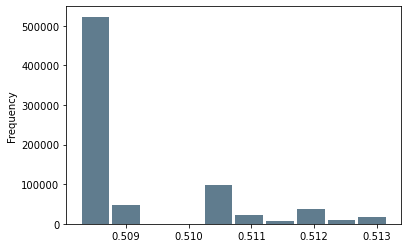

In [42]:
#metrics calculation
cutoff=np.percentile(X_test['RISK_SCORE'],95)
ypred=pd.Series(X_test['RISK_SCORE']).apply(lambda x : 1 if x >cutoff else 0 )
#ypred=pd.Series(ypred_test).apply(lambda x : 1 if x > 0.48631722 else 0 )

print(confusion_matrix(y_test, ypred))
pd.Series(ypred_test).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

print("\n Log Loss is :",log_loss(y_test, ypred_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, ypred_test)))

In [43]:
# retrieve performance metrics
results = bst.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

Text(0.5, 1.0, 'XGBoost AUC')

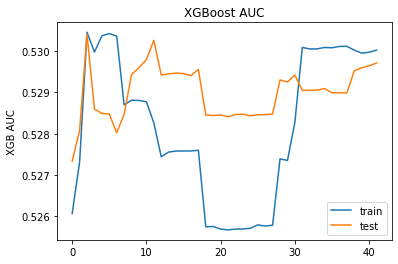

In [44]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='train')
ax.plot(x_axis, results['validation_1']['auc'], label='test')

ax.legend()
plt.ylabel('XGB AUC')
plt.title('XGBoost AUC')

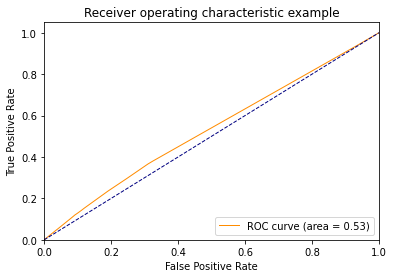

In [45]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.ravel(), ypred_test.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[Text(-2.5, 0, ''),
 Text(0.0, 0, ''),
 Text(2.5, 0, ''),
 Text(5.0, 0, ''),
 Text(7.5, 0, ''),
 Text(10.0, 0, ''),
 Text(12.5, 0, ''),
 Text(15.0, 0, ''),
 Text(17.5, 0, ''),
 Text(20.0, 0, '')]

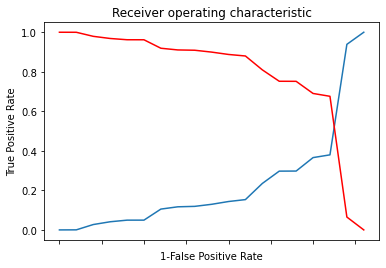

In [46]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [47]:
optimal_idx = np.argmax(tpr - fpr)  ## check it once 
optimal_threshold = thresholds[optimal_idx]
print("\n Optimal Cut off :",optimal_threshold)


 Optimal Cut off : 0.5091623


In [48]:
## Bad rates in overall population 
cd=pd.DataFrame(df[['RISK_SCORE','RISK_FSTQPD30']]).sort_values(by=['RISK_SCORE'],ascending=False)
print("\nTotal bad :",df['RISK_FSTQPD30'].sum())
print("Bad captured in worst category :",'{:,.2%}'.format(cd.groupby(pd.qcut(cd['RISK_SCORE'],10,duplicates='drop')).sum()['RISK_FSTQPD30'][-1]/df['RISK_FSTQPD30'].sum()))
print("\n",cd.groupby(pd.qcut(cd['RISK_SCORE'],10,duplicates='drop')).mean())
print(cd.groupby(pd.qcut(cd['RISK_SCORE'],10,duplicates='drop')).sum())


Total bad : 49938
Bad captured in worst category : 21.60%

                                    RISK_SCORE  RISK_FSTQPD30
RISK_SCORE                                                  
(-0.0007210000000000001, 0.00362]    0.002702       0.016127
(0.00362, 0.00483]                   0.004247       0.024134
(0.00483, 0.00589]                   0.005364       0.028158
(0.00589, 0.00693]                   0.006408       0.032908
(0.00693, 0.00804]                   0.007475       0.039390
(0.00804, 0.00928]                   0.008647       0.046276
(0.00928, 0.0109]                    0.010010       0.058758
(0.0109, 0.0132]                     0.011939       0.069616
(0.0132, 0.0171]                     0.014926       0.085528
(0.0171, 0.415]                      0.023923       0.110429
                                    RISK_SCORE  RISK_FSTQPD30
RISK_SCORE                                                   
(-0.0007210000000000001, 0.00362]   263.865016           1575
(0.00362, 0.00483]   

In [49]:
## Bad rates in overall population 
cdt=pd.DataFrame(outtest[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : 11.91%

Total bads in test sample: 33936
                      pred       act
pred                                
(0.5082, 0.5087]  0.508664  0.041121
(0.5087, 0.5092]  0.509079  0.048150
(0.5092, 0.5106]  0.510614  0.048116
(0.5106, 0.5111]  0.510813  0.051737
(0.5111, 0.5132]  0.512054  0.057643
                           pred    act
pred                                  
(0.5082, 0.5087]  260384.593750  21050
(0.5087, 0.5092]   29402.876953   2781
(0.5092, 0.5106]   22603.873047   2130
(0.5106, 0.5111]   38821.824219   3932
(0.5111, 0.5132]   35914.980469   4043


In [50]:
## Pillar  approach to combine score
hcc_score = 'RISK_SCORE'
X_pillar_train = pd.DataFrame()
X_pillar_test = pd.DataFrame()

X_pillar_train[hcc_score]=df_train['RISK_SCORE']; 
X_pillar_test[hcc_score]=df_test['RISK_SCORE']

X_pillar_train["XGB_SCORE"] =  bst.predict_proba(df_train[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]
X_pillar_test["XGB_SCORE"]  =  bst.predict_proba(df_test[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

X_pillar_train["FSTQ"] = df_train['RISK_FSTQPD30']
X_pillar_test["FSTQ"] = df_test['RISK_FSTQPD30']

X_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['RISK_SCORE','XGB_SCORE']]
y_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['FSTQ']]

X_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['RISK_SCORE','XGB_SCORE']]
y_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['FSTQ']]

X_train_log = np.log((X_train_log + 1e-10).divide(1 - (X_train_log + 1e-10)))
X_test_log = np.log((X_test_log + 1e-10).divide(1 - (X_test_log + 1e-10)))




In [51]:
df["RISK_SCORE_LOG"]= np.log((df["RISK_SCORE"] + 1e-10).divide(1 - (df["RISK_SCORE"] + 1e-10)))
df["XGB_SCORE_LOG"]= np.log((df["XGB_SCORE"] + 1e-10).divide(1 - (df["XGB_SCORE"] + 1e-10)))


In [52]:
logreg = LogisticRegression(C=11, n_jobs=cpu)

# cross validation gini
kfolds = StratifiedKFold(10, random_state=1)
# auc_cv = cross_val_score(logreg, X_train_log, y_train_log, scoring='roc_auc',
#                          cv=kfolds.split(X_test_log, y_test_log), n_jobs=cpu)
# gini_cv = (2 * np.array(auc_cv) - 1).mean()

logreg.fit(X_train_log, np.ravel(y_train_log))
log_coef_tbl = pd.DataFrame({'predictor': ['intercept'] + X_train_log.columns.tolist(),
                             'coefficient': list(logreg.intercept_) + list(logreg.coef_[0])})
log_coef_tbl = log_coef_tbl[['predictor', 'coefficient']]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [53]:
log_coef_tbl

,predictor,coefficient
0,intercept,-0.210181
1,RISK_SCORE,0.693030
2,XGB_SCORE,23.011064


In [54]:
## Model performance
ypred_train_pillar = logreg.predict_proba(X_train_log)[:, 1]
metric_auc_train_log = metrics.roc_auc_score(np.ravel(y_train_log), ypred_train_pillar)
gini_train_pillar = 2 * metric_auc_train_log - 1
ypred_test_pillar = logreg.predict_proba(X_test_log)[:, 1]
metric_auc_test_log = metrics.roc_auc_score(np.ravel(y_test_log), ypred_test_pillar)
gini_test_pillar = 2 * metric_auc_test_log - 1

print("GINI TRAIN:",gini_train_pillar )
print("GINI TEST:",gini_test_pillar )
# print("GINI CV:",gini_cv)

GINI TRAIN: 0.2417440190189457
GINI TEST: 0.3521366962959471


In [55]:
df["COMBINED_SCORE"] = logreg.predict_proba(df[['RISK_SCORE_LOG', 'XGB_SCORE_LOG']])[:, 1]

In [56]:
print("COMBINED:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["COMBINED_SCORE"])-1)
print("RISK:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["RISK_SCORE"])-1)
print("XGB:",2*metrics.roc_auc_score(df["RISK_FSTQPD30"], df["XGB_SCORE"])-1)


COMBINED: 0.3330736846137259
RISK: 0.32845107708805865
XGB: 0.055959494985142966


In [57]:
df.to_pickle(os.getcwd()+"\scored_cd_new.pkl")

In [58]:
df.to_csv(os.getcwd()+"\scored_cd_new.csv")

In [59]:
outtest1=df_train;  outtest1['pred']=ypred_train_pillar ; outtest1['act']=ypred ; 
# outtest1.to_csv(r"clx\\comb_cd_fstq_clx_mix.csv")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[[692673  29386]
 [ 33454   4550]]


<AxesSubplot:ylabel='Frequency'>

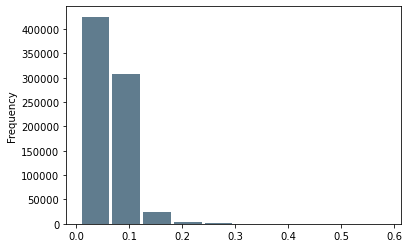

In [60]:
#metrics calculation
cutoff=np.percentile(ypred_test_pillar,95)
ypred=pd.Series(ypred_test_pillar).apply(lambda x : 1 if x >cutoff else 0 )

print(confusion_matrix(ypred,df_test['RISK_FSTQPD30'] ))
pd.Series(ypred_test_pillar).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

In [61]:
print("\n Log Loss is :",log_loss(df_test['RISK_FSTQPD30'], ypred_test_pillar))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(df_test['RISK_FSTQPD30'], ypred_test_pillar)))


 Log Loss is : 0.17922429515488655
Average precision-recall score: 0.09


In [62]:
len(ypred_test_pillar)

760063

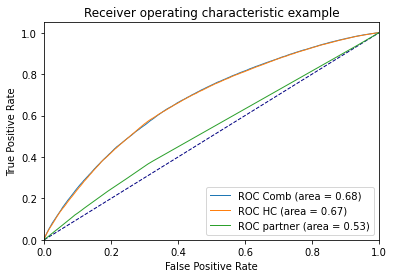

In [63]:
## PRC curve
#precision, recall, _ = precision_recall_curve(ypred, ypred_test_pillar)

# step_kwargs = ({'step': 'post'}
#                #if 'step' in signature(plt.fill_between).parameters
#                #else {}
#               )
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 0.5])
# plt.xlim([0.0, 0.5])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(test['RISK_FSTQPD30'], ypred_test_pillar)))

# # calculate precision-recall AUC
# auc_pr = auc(recall, precision)
# print("\n AUC for precision-recall :",auc_pr)

# Compute micro-average ROC curve and ROC area
fprhc, tprhc, thresholds = roc_curve(df_test['RISK_FSTQPD30'], df_test['RISK_SCORE'].ravel())
roc_auchc = auc(fprhc, tprhc)

fprc, tprc, thresholds = roc_curve(df_test['RISK_FSTQPD30'], ypred_test_pillar.ravel())
roc_aucc = auc(fprc, tprc)

plt.figure()
lw = 1
plt.plot(fprc, tprc, lw=lw, label='ROC Comb (area = %0.2f)' % roc_aucc)
plt.plot(fprhc, tprhc, lw=lw, label='ROC HC (area = %0.2f)' % roc_auchc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr, tpr, lw=lw, label='ROC partner (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [64]:
## Bad rates combined score in overall population 
cdt=pd.DataFrame(outtest1[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : nan%

Total bads in test sample: 0.0
                       pred  act
pred                            
(0.00545, 0.0393]  0.031435  NaN
(0.0393, 0.0486]   0.044191  NaN
(0.0486, 0.0563]   0.052516  NaN
(0.0563, 0.0632]   0.059775  NaN
(0.0632, 0.0701]   0.066631  NaN
(0.0701, 0.0775]   0.073703  NaN
(0.0775, 0.0859]   0.081654  NaN
(0.0859, 0.0967]   0.091044  NaN
(0.0967, 0.112]    0.103680  NaN
(0.112, 0.604]     0.134220  NaN
                          pred  act
pred                               
(0.00545, 0.0393]   680.845951  0.0
(0.0393, 0.0486]    957.084752  0.0
(0.0486, 0.0563]   1137.397040  0.0
(0.0563, 0.0632]   1294.605954  0.0
(0.0632, 0.0701]   1443.104349  0.0
(0.0701, 0.0775]   1596.266837  0.0
(0.0775, 0.0859]   1768.464917  0.0
(0.0859, 0.0967]   1971.838530  0.0
(0.0967, 0.112]    2245.491983  0.0
(0.112, 0.604]     2906.940002  0.0


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
